# K近邻算法

kNN算法是一种基于实例的分类算法，对于给定标签的训练集，计算新数据与训练集实例的距离，统计最近的k个实例，如果多数属于某一类，则新实例属于该类。

**导入数据并清洗**

In [1]:
import pandas as pd

wh_data = pd.read_csv('../AQI_maincity/武汉.csv', index_col='date', encoding='utf-8', engine='python')
wh_data.drop(index=wh_data[wh_data['质量等级']=='无'].index, inplace=True) # 删除异常值

In [2]:
def get_grade(data):
    if data <100:
        return 0
    elif 100 <= data < 200:
        return 1
    elif data >= 200:
        return 2

In [3]:
wh_data['GRADE'] = wh_data.AQI.apply(get_grade)
wh_data.dropna(inplace=True)
wh_data.head()

,AQI,质量等级,PM2.5,PM10,SO2,CO,NO2,O3_8h,GRADE
date,,,,,,,,,
2014-01-01,203,重度污染,153,210,70,2.0,106,55,2
2014-01-02,231,重度污染,181,254,89,2.4,112,26,2
2014-01-03,224,重度污染,174,226,63,1.7,84,55,2
2014-01-04,147,轻度污染,112,184,73,1.6,87,40,1
2014-01-05,195,中度污染,147,213,89,2.2,91,53,1


**查看数据分布**

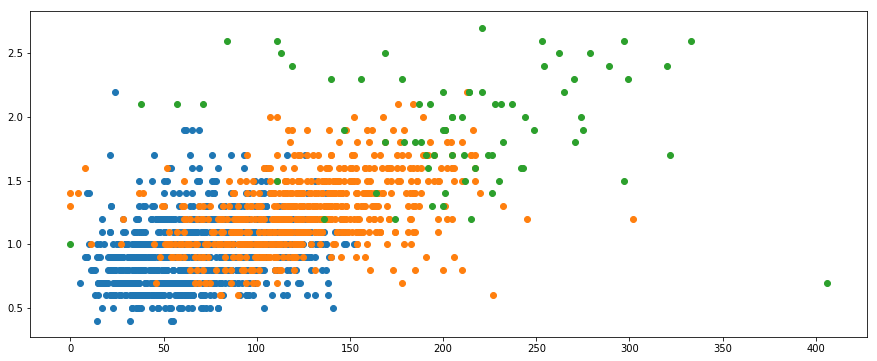

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = wh_data.loc[:, ['PM10','CO']]
y = wh_data.loc[:, 'GRADE']

plt.figure(figsize=(15,6))
for label in np.unique(y):
    plt.scatter(X.loc[y[y==label].index, 'PM10'], X.loc[y[y==label].index, 'CO'])
plt.show()

**划分测试集**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

**模型拟合**

In [6]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [7]:
knn_clf.score(X_test, y_test)

0.7819383259911894

**标准化**

In [8]:
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train_sca = standardscaler.transform(X_train)
X_test_sca = standardscaler.transform(X_test)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_sca, y_train)
knn_clf.score(X_test_sca, y_test)

0.7863436123348018

**调整k**

In [9]:
best_k = 0
best_score = 0.
for k in range(1,11,2):
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train_sca, y_train)
    score = knn_clf.score(X_test_sca, y_test)
    if score > best_score:
        best_score = score
        best_k = k
print(best_k, best_score)

9 0.8105726872246696


**调整权重**

In [10]:
best_k = 0
best_score = 0.
for k in range(1,16,2):
    knn_clf = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_clf.fit(X_train_sca, y_train)
    score = knn_clf.score(X_test_sca, y_test)
    if score > best_score:
        best_score = score
        best_k = k
print(best_k, best_score)

11 0.7863436123348018


**调整p**

In [11]:
best_k = 0
best_score = 0.
best_weight = ''
best_p = 0
for weight in ['uniform', 'distance']:
    for p in range(1,6):
        for k in range(1,11):
            knn_clf = KNeighborsClassifier(n_neighbors=k, weights=weight, p=p)
            knn_clf.fit(X_train_sca, y_train)
            score = knn_clf.score(X_test_sca, y_test)
            if score > best_score:
                best_score = score
                best_k = k
                best_weight = weight
                best_p = p
print(best_k, best_weight, best_p, best_score)

8 uniform 3 0.8215859030837004


**网格搜索**

In [12]:
knn_clf = KNeighborsClassifier()

param_grid = [
    {
        'weights': ['uniform', 'distance'], 
        'n_neighbors': [i for i in range(1, 16)],
        'p': [i for i in range(1, 11)]
    }
]

In [13]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(knn_clf, param_grid, cv=10, n_jobs=-1)

In [14]:
standardscaler = StandardScaler()
standardscaler.fit(X)
X_sca = standardscaler.transform(X)

In [15]:
grid_search.fit(X_sca, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
grid_search.best_params_

{'n_neighbors': 14, 'p': 7, 'weights': 'uniform'}

In [17]:
grid_search.best_score_

0.8087100330760749

In [18]:
knn_clf = KNeighborsClassifier(n_neighbors=14, p=7, weights='uniform')
knn_clf.fit(X_sca, y)
knn_clf.score(X_sca, y)

0.8235942668136714

# kNN Regressor

In [19]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_sca, y_train)
knn_reg.score(X_test_sca, y_test)

0.5436604421787554